In [1]:
import re

In [3]:
def parse_alb(alb_file_name):
    """Reads assembly line balancing instance .alb file, returns dictionary with the information"""
    parse_dict = {}
    alb_file = open(alb_file_name).read()
    # Get number of tasks
    num_tasks = re.search("<number of tasks>\n(\\d*)", alb_file)
    parse_dict["num_tasks"] = int(num_tasks.group(1))

    # Get cycle time
    cycle_time = re.search("<cycle time>\n(\\d*)", alb_file)
    parse_dict["cycle_time"] = int(cycle_time.group(1))

    # Order Strength
    order_strength = re.search("<order strength>\n(\\d*,\\d*)", alb_file)
    
    if order_strength:
        parse_dict["original_order_strength"] = float(order_strength.group(1).replace(",", "."))
    else:
        order_strength = re.search("<order strength>\n(\\d*.\\d*)", alb_file)
        parse_dict["original_order_strength"] = float(order_strength.group(1))

    # Task_times
    task_times = re.search("<task times>(.|\n)+?<", alb_file)

    # Get lines in this regex ignoring the first and last 2
    task_times = task_times.group(0).split("\n")[1:-2]
    task_times = {task.split()[0]: int(task.split()[1]) for task in task_times}
    parse_dict["task_times"] = task_times

    # Precedence relations
    precedence_relations = re.search("<precedence relations>(.|\n)+?<", alb_file)
    precedence_relations = precedence_relations.group(0).split("\n")[1:-2]
    precedence_relations = [task.split(",") for task in precedence_relations]
    parse_dict["precedence_relations"] = precedence_relations
    return parse_dict

def write_to_alb(salbp_dict, alb_file_name):
    """Writes the SALBP dictionary to an .alb file"""
    #Format of alb:
    # <number of tasks>
    # no_tasks
    # <cycle time>
    # cycle_time
    #<task times>
    #task_id task_time
    #<precedence relations>
    #task_id,task_id


    # Write number of tasks
    alb = "<number of tasks>\n"
    alb += str(salbp_dict["num_tasks"]) + "\n"
    # Write cycle time
    alb += "<cycle time>\n"
    alb += str(salbp_dict["cycle_time"]) + "\n"
    # Write task times
    alb += "<task times>\n"
    for task_id, task_time in salbp_dict["task_times"].items():
        alb += task_id + " " + str(task_time) + "\n"
    # Write precedence relations
    alb += "<precedence relations>\n"
    for relation in salbp_dict["precedence_relations"]:
        alb += relation[0] + "," + relation[1] + "\n"
    #ends the file
    alb += "<end>"
    with open(alb_file_name, "w") as alb_file:
        alb_file.write(alb)
    


SALBP_dict = parse_alb("small data set_n=20/instance_n=20_2.alb")
write_to_alb(SALBP_dict, "test.alb")

In [ ]:
SALBP_dict

{'num_tasks': 20,
 'cycle_time': 1000,
 'original_order_strength': 0.3,
 'task_times': {'1': 58,
  '2': 224,
  '3': 20,
  '4': 150,
  '5': 410,
  '6': 117,
  '7': 262,
  '8': 94,
  '9': 213,
  '10': 118,
  '11': 191,
  '12': 74,
  '13': 60,
  '14': 117,
  '15': 124,
  '16': 103,
  '17': 178,
  '18': 188,
  '19': 107,
  '20': 53},
 'precedence_relations': [['1', '13'],
  ['2', '5'],
  ['4', '6'],
  ['5', '10'],
  ['5', '11'],
  ['5', '12'],
  ['6', '7'],
  ['6', '8'],
  ['6', '9'],
  ['7', '13'],
  ['8', '13'],
  ['9', '13'],
  ['10', '16'],
  ['11', '14'],
  ['12', '15'],
  ['13', '17'],
  ['13', '18'],
  ['13', '19'],
  ['13', '20']]}

In [4]:
! ./BBR-for-SALBP1/SALB/SALB/salb   "test.alb" 

test.alb
n=20
cycle time=1000
t1=58 t2=224 t3=20 t4=150 t5=410 t6=117 t7=262 t8=94 t9=213 t10=118 t11=191 t12=74 t13=60 t14=117 t15=124 t16=103 t17=178 t18=188 t19=107 t20=53 
running forward 2560000 2560000
MHH upper bound: 3 (0.00s)
First lower bound: 3
Optimality proved by LB1
Solution with 3 stations
 1	1
2	1
3	3
4	2
5	1
6	2
7	3
8	2
9	2
10	2
11	1
12	2
13	3
14	1
15	2
16	2
17	3
18	3
19	3
20	3
test test test.sol
   verified_optimality = 1; value = 3; cpu = 0.00
Hoffman cpu =   0.00  best_first_bbr cpu =   0.00  bfs_bbr cpu =   0.00 find_insert_cpu =   0.00  bin_cpu =   0.00  cpu =   0.00


In [ ]:
import subprocess
import pandas as pd
from copy import deepcopy

def random_task_time_change(SALBP_dict, multiplier = 1.5):
    """Increases a random task time by 1"""
    import random
    task_id = random.choice(list(SALBP_dict["task_times"].keys()))
    SALBP_dict["task_times"][task_id] *= multiplier
    return SALBP_dict

def task_time_change(SALBP_dict, task_id, multiplier = 1.5, debug = False):
    """Increases a random task time by 1"""
    if debug:
        print("Changing task", task_id, "time by", multiplier)
    SALBP_dict["task_times"][task_id] *= multiplier
    return SALBP_dict

def precedence_removal(SALBP_dict, edge_index):
    """Removes a precedence relation"""
    print("precedence_relations", len(SALBP_dict["precedence_relations"]))
    print("edge_index", edge_index)
    SALBP_dict["precedence_relations"].pop(edge_index)
    return SALBP_dict
    

def parse_bb_salb1_out(text):
    '''gets the number of stations, optimal flag and cpu time from the output of the salb1 program'''
    output = text.stdout.decode("utf-8")
    # Regular expression to capture the required values
    match = re.search(r"verified_optimality\s*=\s*(\d+);\s*value\s*=\s*(\d+);\s*cpu\s*=\s*([\d.]+)", output)

    if match:
        verified_optimality = int(match.group(1))
        value = int(match.group(2))
        cpu = float(match.group(3))

        print("verified_optimality:", verified_optimality)
        print("value:", value)
        print("cpu:", cpu)
    else:
        print("Pattern not found.")
    return value, verified_optimality, cpu

def generate_results(fp = "/Users/letshopethisworks2/Documents/phd_paper_material/MMABPWW/SALBP_benchmark/small data set_n=20/" ,  instance_name = "instance_n=20_", ext = ".alb", start=1, stop = 300):
    results = []
    for i in range(start,stop):
        SALBP_dict_orig = parse_alb(f"{fp}{instance_name}{i}{ext}")
        bin_dict = deepcopy(SALBP_dict_orig)
        for j in range(len(SALBP_dict_orig["precedence_relations"])):
            SALBP_dict = deepcopy(SALBP_dict_orig)
            print("SALBP_dict_orig precedence", len(SALBP_dict_orig["precedence_relations"]))
            SALBP_dict =precedence_removal(SALBP_dict, j)
            write_to_alb(SALBP_dict, "test.alb")
            output = subprocess.run(["./BBR-for-SALBP1/SALB/SALB/salb", "test.alb"], stdout=subprocess.PIPE)
            no_stations, optimal, cpu = parse_bb_salb1_out(output)
            result = {"instance:": f"instance_n=20_{i}", "precedence_relation": j, "no_stations": no_stations, "optimal": optimal, "cpu": cpu}
            
            results.append(result)

        #calculates bin packing lower bound
        bin_dict['precedence_relations'] = []
        write_to_alb(bin_dict, "test.alb")
        output = subprocess.run(["./BBR-for-SALBP1/SALB/SALB/salb", "test.alb"], stdout=subprocess.PIPE)
        no_stations, optimal, cpu = parse_bb_salb1_out(output)
        result = {"instance:": f"instance_n=20_{i}", "precedence_relation": "None", "no_stations": no_stations, "optimal": optimal, "cpu": cpu}
        results.append(result)
    return results

#reads the results csv
#results_df = pd.read_csv("task_20_bin_lb.csv")
#results_df = pd.DataFrame(results)
#saves the results df to a csv file
#results_df.to_csv("tasks20_test.csv")
results = generate_results(fp = "/Users/letshopethisworks2/Documents/phd_paper_material/MMABPWW/SALBP_benchmark/medium data set_n=50/", instance_name = "instance_n=50_", start=100, stop = 300)
results_df = pd.DataFrame(results)
results_df.to_csv("tasks50_test.csv")

SALBP_dict_orig precedence 88
precedence_relations 88
edge_index 0
verified_optimality: 1
value: 7
cpu: 0.0
SALBP_dict_orig precedence 88
precedence_relations 88
edge_index 1
verified_optimality: 1
value: 7
cpu: 0.0
SALBP_dict_orig precedence 88
precedence_relations 88
edge_index 2
verified_optimality: 1
value: 7
cpu: 0.0
SALBP_dict_orig precedence 88
precedence_relations 88
edge_index 3
verified_optimality: 1
value: 7
cpu: 0.0
SALBP_dict_orig precedence 88
precedence_relations 88
edge_index 4
verified_optimality: 1
value: 7
cpu: 0.0
SALBP_dict_orig precedence 88
precedence_relations 88
edge_index 5
verified_optimality: 1
value: 7
cpu: 0.0
SALBP_dict_orig precedence 88
precedence_relations 88
edge_index 6
verified_optimality: 1
value: 7
cpu: 0.0
SALBP_dict_orig precedence 88
precedence_relations 88
edge_index 7
verified_optimality: 1
value: 7
cpu: 0.0
SALBP_dict_orig precedence 88
precedence_relations 88
edge_index 8
verified_optimality: 1
value: 7
cpu: 0.0
SALBP_dict_orig precedence 8

In [ ]:
#results_df.to_csv("task_20_bin_lb.csv")

In [ ]:
results_df.head(20)

,Unnamed: 0,instance:,precedence_relation,no_stations,optimal,cpu
0,0,instance_n=20_1,0.0,3,1,0.0
1,1,instance_n=20_1,1.0,3,1,0.0
2,2,instance_n=20_1,2.0,3,1,0.0
3,3,instance_n=20_1,3.0,3,1,0.0
4,4,instance_n=20_1,4.0,3,1,0.0
5,5,instance_n=20_1,5.0,3,1,0.0
6,6,instance_n=20_1,6.0,3,1,0.0
7,7,instance_n=20_1,7.0,3,1,0.0
8,8,instance_n=20_1,8.0,3,1,0.0
9,9,instance_n=20_1,9.0,3,1,0.0


In [ ]:
lb_df = results_df[results_df["precedence_relation"].isna() == True].copy()
#removes the rows with None precedence relations
results_df = results_df[results_df['precedence_relation'].isna() == False]

lb_df

,Unnamed: 0,instance:,precedence_relation,no_stations,optimal,cpu
16,16,instance_n=20_1,NaN,3,1,0.0
36,36,instance_n=20_2,NaN,3,1,0.0
55,55,instance_n=20_3,NaN,3,1,0.0
74,74,instance_n=20_4,NaN,3,1,0.0
93,93,instance_n=20_5,NaN,3,1,0.0
...,...,...,...,...,...,...
6486,6486,instance_n=20_295,NaN,3,1,0.0
6502,6502,instance_n=20_296,NaN,3,1,0.0
6520,6520,instance_n=20_297,NaN,3,1,0.0
6535,6535,instance_n=20_298,NaN,3,1,0.0


In [ ]:
results_df.head(20)

,Unnamed: 0,instance:,precedence_relation,no_stations,optimal,cpu
0,0,instance_n=20_1,0.0,3,1,0.0
1,1,instance_n=20_1,1.0,3,1,0.0
2,2,instance_n=20_1,2.0,3,1,0.0
3,3,instance_n=20_1,3.0,3,1,0.0
4,4,instance_n=20_1,4.0,3,1,0.0
5,5,instance_n=20_1,5.0,3,1,0.0
6,6,instance_n=20_1,6.0,3,1,0.0
7,7,instance_n=20_1,7.0,3,1,0.0
8,8,instance_n=20_1,8.0,3,1,0.0
9,9,instance_n=20_1,9.0,3,1,0.0


In [ ]:
#gets the min and max number of stations for each instance
min_and_max = results_df.groupby("instance:")["no_stations"].agg(["min", "max"])
min_and_max.reset_index(inplace = True)
#adds in lb values
lb_df['bin_lb'] = lb_df['no_stations']
min_and_max = pd.merge(min_and_max, lb_df[["instance:", "bin_lb"]], on = "instance:")
min_and_max

,instance:,min,max,bin_lb
0,instance_n=20_1,3,3,3
1,instance_n=20_10,3,3,3
2,instance_n=20_100,11,11,11
3,instance_n=20_101,12,13,12
4,instance_n=20_102,12,13,11
...,...,...,...,...
294,instance_n=20_95,11,12,10
295,instance_n=20_96,10,10,10
296,instance_n=20_97,14,15,13
297,instance_n=20_98,13,13,13


In [ ]:
#counts the number of times min does not equal max
min_and_max["min_not_equal_max"] = min_and_max["min"] != min_and_max["max"]
min_and_max["min_not_equal_max"].sum()

27

In [ ]:
#counts the number of time the bin_lb is less than the min
min_and_max["bin_lb_less_than_min"] = min_and_max["bin_lb"] < min_and_max["min"]
min_and_max["bin_lb_less_than_min"].sum()

7

In [ ]:
#counts the number of time the bin_lb is less than the max
min_and_max["bin_lb_less_than_max"] = min_and_max["bin_lb"] < min_and_max["max"]
print("bin lb dif", min_and_max["bin_lb_less_than_max"].sum())
#filters for the instances where the bin_lb is les than the max
min_and_max[min_and_max["bin_lb_less_than_max"] == True]

bin lb dif 30


,instance:,min,max,bin_lb,bin_lb_less_than_min,bin_lb_less_than_max
3,instance_n=20_101,12,13,12,False,True
4,instance_n=20_102,12,13,11,True,True
5,instance_n=20_103,11,12,11,False,True
41,instance_n=20_136,5,6,5,False,True
86,instance_n=20_177,9,10,9,False,True
96,instance_n=20_186,13,14,13,False,True
158,instance_n=20_241,12,13,12,False,True
161,instance_n=20_244,10,11,10,False,True
162,instance_n=20_245,13,13,12,True,True
164,instance_n=20_247,10,11,10,False,True


In [ ]:
#prints the instances where min does not equal max
interesting_instances = min_and_max[min_and_max["min_not_equal_max"]]

In [ ]:
inst_20_101 = results_df[results_df["instance:"] == "instance_n=20_101"]
inst_20_101

,Unnamed: 0,instance:,precedence_relation,no_stations,optimal,cpu
1993,1993,instance_n=20_101,0,12,1,0.02
1994,1994,instance_n=20_101,1,13,1,0.02
1995,1995,instance_n=20_101,2,13,1,0.01
1996,1996,instance_n=20_101,3,13,1,0.01
1997,1997,instance_n=20_101,4,13,1,0.01
1998,1998,instance_n=20_101,5,13,1,0.01
1999,1999,instance_n=20_101,6,12,1,0.01
2000,2000,instance_n=20_101,7,12,1,0.01
2001,2001,instance_n=20_101,8,12,1,0.01
2002,2002,instance_n=20_101,9,13,1,0.01


/var/folders/6v/7nrd1rj91hx3tb4q5npbdf0w0000gn/T/ipykernel_77386/2280055115.py:78: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap("Set1", num_colors)  # Use a qualitative colormap


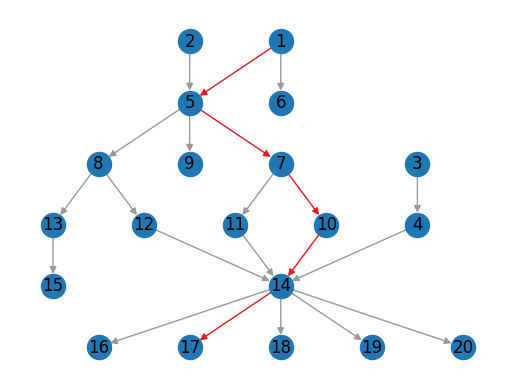

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt
import pydot
import matplotlib.cm as cm
import matplotlib.colors as mcolors

def plot_salbp_graph(SALBP_dict):
    G = nx.DiGraph()
    G.add_nodes_from(SALBP_dict["task_times"].keys())
    G.add_edges_from(SALBP_dict["precedence_relations"])
    #prints the edges
    print("from dict", SALBP_dict["precedence_relations"])
    #prints the edges from the graph
    print("from graph", G.edges())
    nx.draw(G, with_labels = True)
    plt.show()

def plot_salbp_edge_removal_graph(SALBP_dict, instance_name, res_df):
    '''Colors the edges by the number of stations in res_df'''
    G = nx.DiGraph()
    G.add_nodes_from(SALBP_dict["task_times"].keys())
    G.add_edges_from(SALBP_dict["precedence_relations"])
    edge_colors = []
    for edge in G.edges():
        edge_index = SALBP_dict["precedence_relations"].index(list(edge))
        no_stations = res_df[(res_df["instance:"] == instance_name) & (res_df["precedence_relation"] == edge_index)]["no_stations"].values[0]
        edge_colors.append(no_stations)
    #saves edge colors as graph attribute
    nx.set_edge_attributes(G, dict(zip(G.edges(), edge_colors)), "value")
    pos = nx.nx_pydot.graphviz_layout(G, prog = "dot")
   # Define colormap
    unique_values = list(set(edge_colors))
    print(unique_values)
    color_map = cm.get_cmap('viridis', len(unique_values))
    print("color map", color_map)
    cmap = mcolors.ListedColormap([color_map(val) for val in unique_values])

    # Draw graph
    #creates ax
    fig, ax = plt.subplots()
    edges = nx.draw_networkx_edges(G, pos, edge_color=edge_colors, edge_cmap=cmap, edge_vmin=min(edge_colors), edge_vmax=max(edge_colors), ax=ax)
    nx.draw_networkx_nodes(G, pos, ax=ax)
    nx.draw_networkx_labels(G, pos, ax=ax)

    # Add colorbar
    handles = [plt.Line2D([0], [0], marker='o', color = color_map(val), label=val, markersize=10) for val in unique_values]
    plt.legend(handles=handles, loc="best")

    plt.show()
    return G


def draw_graph_with_discrete_legend(SALBP_dict, res_df, instance_name,  ax=None):
    G = nx.DiGraph()
    G.add_nodes_from(SALBP_dict["task_times"].keys())
    G.add_edges_from(SALBP_dict["precedence_relations"])

    edge_colors = []
    edge_values = []  # Store unique edge values for legend

    for edge in G.edges():
        edge_index = SALBP_dict["precedence_relations"].index(list(edge))
        no_stations = res_df[(res_df["instance:"] == instance_name) & 
                             (res_df["precedence_relation"] == edge_index)]["no_stations"].values[0]
        edge_colors.append(no_stations)
        if no_stations not in edge_values:
            edge_values.append(no_stations)

    # Save edge colors as graph attribute
    nx.set_edge_attributes(G, dict(zip(G.edges(), edge_colors)), "value")

    # Graph layout
    pos = nx.nx_pydot.graphviz_layout(G, prog="dot")

    # Define discrete colormap
    unique_values = sorted(edge_values)
    num_colors = len(unique_values)
    cmap = plt.cm.get_cmap("Set1", num_colors)  # Use a qualitative colormap
    color_map = {val: cmap(i) for i, val in enumerate(unique_values)}  # Assign colors to unique values

    # Assign discrete colors to edges
    edge_color_list = [color_map[val] for val in edge_colors]

    # Draw graph
    if ax is None:
        fig, ax = plt.subplots()
    edges = nx.draw_networkx_edges(G, pos, edge_color=edge_color_list, ax=ax)
    nx.draw_networkx_nodes(G, pos, ax=ax)
    nx.draw_networkx_labels(G, pos, ax=ax)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    # Create legend
    handles = [plt.Line2D([0], [0], color=color_map[val], lw=2, label=f"No. of Stations: {val}") for val in unique_values]
    #ax.legend(handles=handles, loc="best")


    return G

i = 97

test_salb = parse_alb(f"/Users/letshopethisworks2/Documents/phd_paper_material/MMABPWW/SALBP_benchmark/small data set_n=20/instance_n=20_{i}.alb")
#test_g = plot_salbp_edge_removal_graph(test_salb, f"instance_n=20_{i}", results_df)
test_g = draw_graph_with_discrete_legend(test_salb, results_df, f"instance_n=20_{i}")
#saves graph to a gephi readable file
nx.write_gexf(test_g, "test_salb.gexf")
#plot_salbp_graph(test_salb)

In [ ]:
interesting_instances['instance:'].values

array(['instance_n=20_101', 'instance_n=20_102', 'instance_n=20_103',
       'instance_n=20_136', 'instance_n=20_177', 'instance_n=20_186',
       'instance_n=20_241', 'instance_n=20_244', 'instance_n=20_247',
       'instance_n=20_25', 'instance_n=20_251', 'instance_n=20_253',
       'instance_n=20_254', 'instance_n=20_255', 'instance_n=20_264',
       'instance_n=20_265', 'instance_n=20_269', 'instance_n=20_270',
       'instance_n=20_271', 'instance_n=20_274', 'instance_n=20_278',
       'instance_n=20_34', 'instance_n=20_38', 'instance_n=20_91',
       'instance_n=20_95', 'instance_n=20_97', 'instance_n=20_99'],
      dtype=object)

/var/folders/6v/7nrd1rj91hx3tb4q5npbdf0w0000gn/T/ipykernel_54065/1149760186.py:78: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap("Set1", num_colors)  # Use a qualitative colormap
/var/folders/6v/7nrd1rj91hx3tb4q5npbdf0w0000gn/T/ipykernel_54065/1149760186.py:78: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap("Set1", num_colors)  # Use a qualitative colormap
/var/folders/6v/7nrd1rj91hx3tb4q5npbdf0w0000gn/T/ipykernel_54065/1149760186.py:78: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``mat

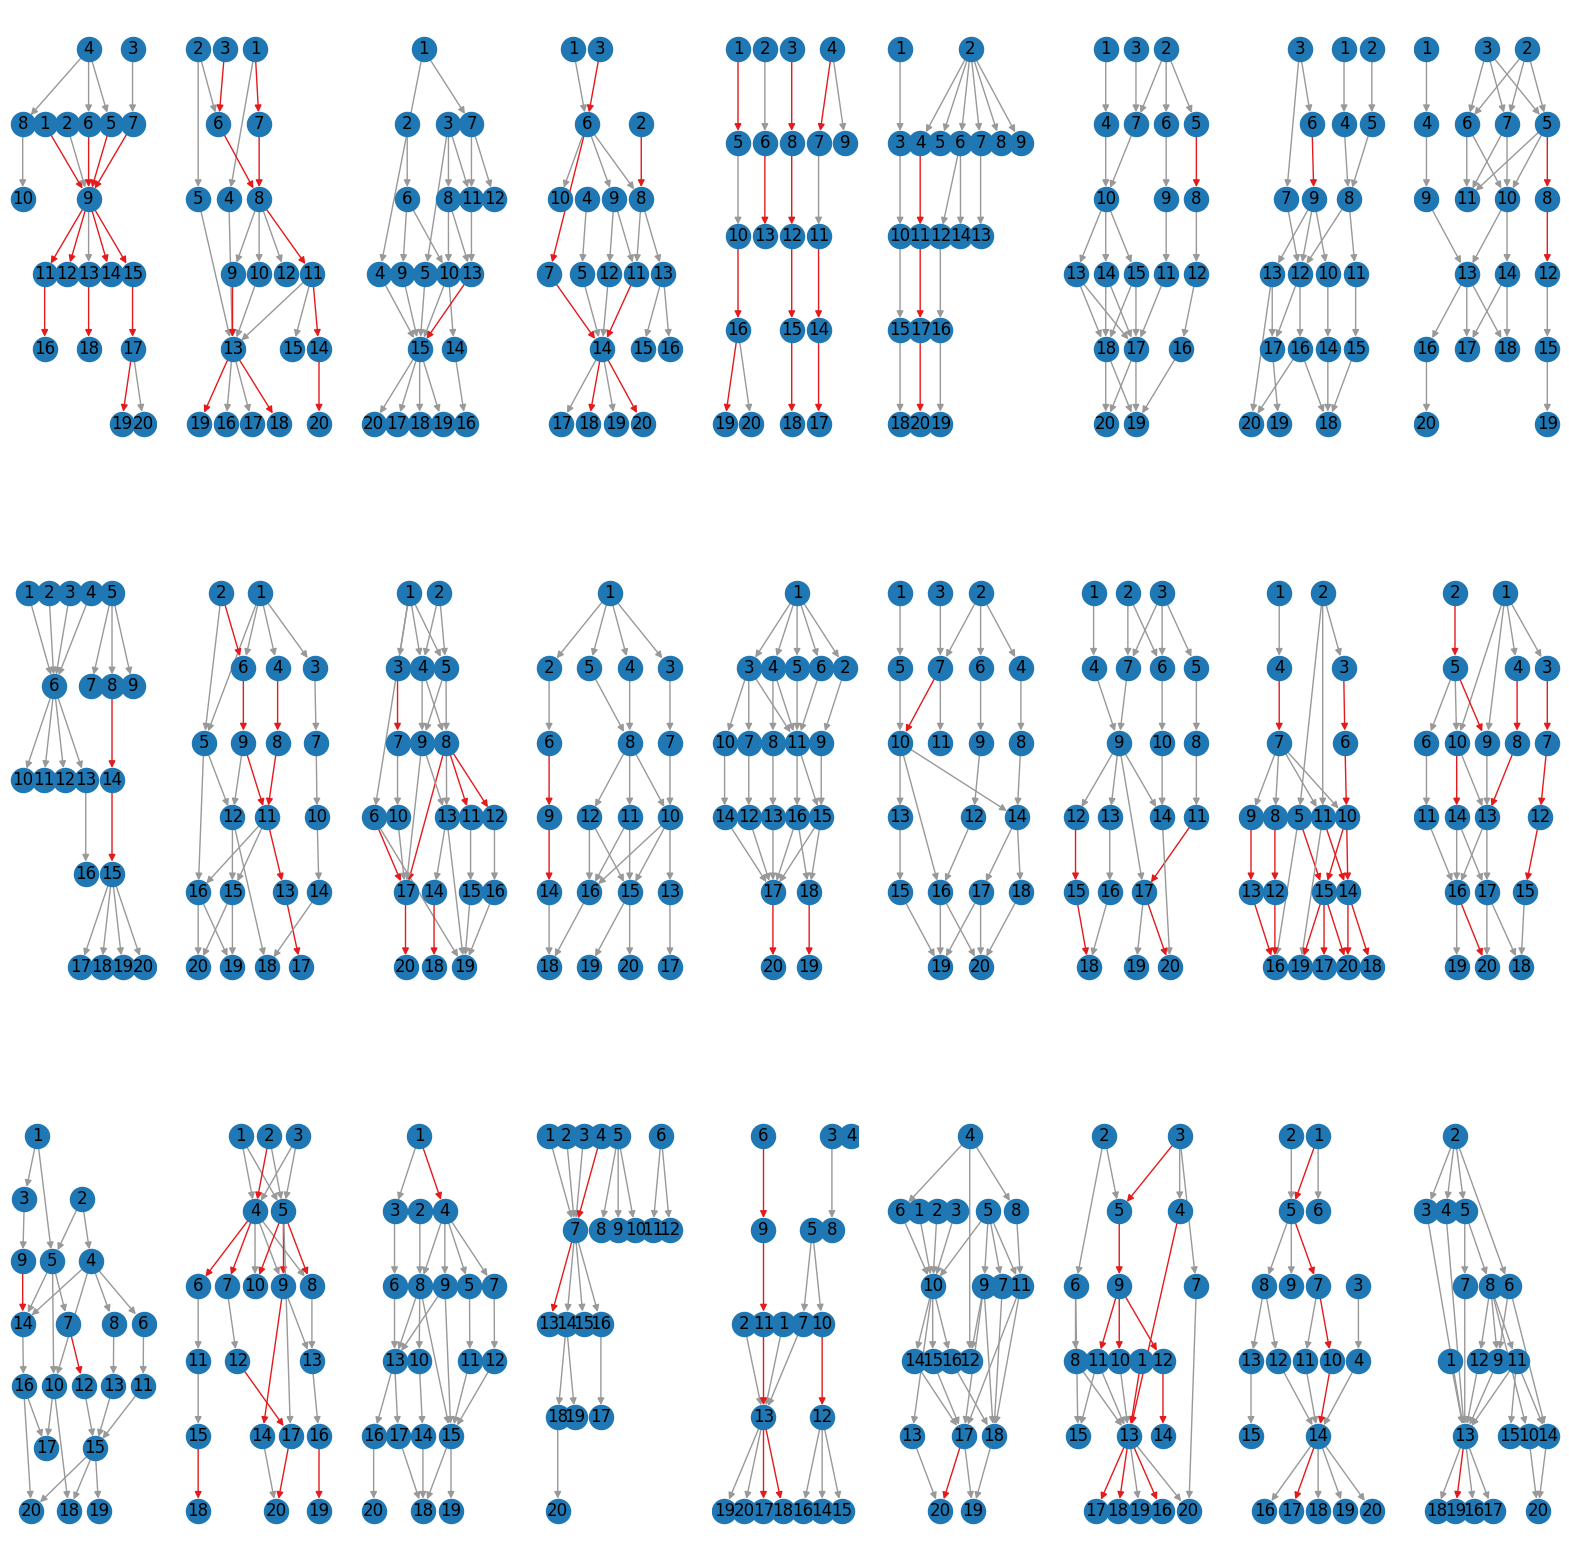

In [ ]:
#creates a plot of the 27 graphs of interest
fig, axs = plt.subplots(3, 9, figsize=(20, 20))
axs = axs.ravel()
for idx, i in enumerate(interesting_instances['instance:'].values):
    test_salb = parse_alb(f"/Users/letshopethisworks2/Documents/phd_paper_material/MMABPWW/SALBP_benchmark/small data set_n=20/{i}.alb")
    #test_g = plot_salbp_edge_removal_graph(test_salb, f"instance_n=20_{i}", results_df)
    test_g = draw_graph_with_discrete_legend(test_salb, results_df, i, ax=axs[idx])
    #adds test_g to the axs

plt.show()